In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))


2025-04-19 10:24:32.339644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745038472.384470    8571 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745038472.398013    8571 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745038472.493998    8571 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745038472.494034    8571 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745038472.494035    8571 computation_placer.cc:177] computation placer alr

2.19.0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import multiprocessing
import gc

data_cfg = {
    'Input_param_names': ['ambient',
                          'coolant',
                          'u_d',
                          'u_q',
                          'motor_speed',
                          #'torque',
                          'i_d',
                          'i_q'
                           ],
    'Target_param_names': ['pm',
                           'stator_yoke',
                           'stator_tooth',
                           'stator_winding'
                          ],
    # for ewm and statistical moments
    'downsample_rate': 1,
    'rolling_lookback': [120,600,3600,7200],
    'valset' : [78, 79, 81],
    'testset' : [27, 29, 30, 31, 65, 72, 4,  5,  6],
    'loss': 'mse',
    # profile ids to drop (don't need to actually exist)

    # paths
    'file_path': "measures.csv",
    'db_path': 'results.db',
    'model_dump_path': 'output/',
    'save_predictions': True,
    'random_seed': 2019,
    'downsample_val_test': True,
    'db_target_scheme': ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding'],
}

# Load dataset
path = 'measures.csv'
conversion_table = {col: np.float32 for col in data_cfg['Input_param_names'] + data_cfg['Target_param_names']}
conversion_table.update({'profile_id': np.uint8})
dataset = pd.read_csv(path, dtype=conversion_table)

# Select relevant columns
x_cols = data_cfg['Input_param_names']
y_cols = data_cfg['Target_param_names']
dataset = dataset.loc[:, x_cols + y_cols + ['profile_id']]                              

# Standardize the data
scaler = StandardScaler()
float_cols = x_cols + y_cols
print("Standardizing columns:", float_cols)
# Convert columns to float before scaling
dataset[float_cols] = scaler.fit_transform(dataset[float_cols].astype(float))

# Create extra features
def calculate_i_s(row):
    return np.sqrt(row['i_d']**2 + row['i_q']**2)

def calculate_u_s(row):
    return np.sqrt(row['u_d']**2 + row['u_q']**2)

def calculate_P_el(row):
    return row['i_s'] * row['u_s']

if set(['i_d', 'i_q', 'u_d', 'u_q']).issubset(set(dataset.columns.tolist())):
    dataset['i_s'] = dataset.apply(calculate_i_s, axis=1)
    dataset['u_s'] = dataset.apply(calculate_u_s, axis=1)
    dataset['P_el'] = dataset.apply(calculate_P_el, axis=1)

# Function to create lag features
def create_lag_features(args):
    df, lookback = args
    dfs = []
    for lback in range(lookback, lookback + 1, lookback):
        lag_feats = [
            df.shift(lback).astype(np.float32).fillna(df.iloc[0, :]).add_suffix(f'_lag_{lback}'),
            df.diff(periods=lback).astype(np.float32).fillna(df.iloc[0, :]).add_suffix(f'_lag_{lback}_diff')
        ]
        lag_feats += [
            abs(lag_feats[1]).astype(np.float32).add_suffix('_abs'),
            pd.DataFrame(df.values + lag_feats[0].values, columns=df.columns).add_suffix(f'_sum')
        ]
        dfs.append(pd.concat(lag_feats, axis=1))
    return pd.concat(dfs, axis=1)

# Function to create rolling features
def create_rolling_features(args):
    df, lookbacks = args
    dfs = []
    for lookback in lookbacks:
        dummy = np.zeros((lookback, len(df.columns)))
        dummy = pd.DataFrame(dummy, columns=df.columns)
        df = pd.concat([dummy, df], axis=0, ignore_index=True)
        ew_mean = pd.concat([df.ewm(span=lookback).mean().astype(np.float32).rename(columns=lambda c: c + '_ew_rolling_mean_' + str(lookback))], axis=1)
        ew_std = pd.concat([df.ewm(span=lookback).std().astype(np.float32).rename(columns=lambda c: c + '_ew_rolling_std_' + str(lookback))], axis=1)
        dfs.append(pd.concat([ew_mean, ew_std], axis=1).iloc[lookback + 1:, :].reset_index(drop=True))
    return pd.concat(dfs, axis=1)

# Apply feature creation in parallel
profiles_df = [dataset.loc[dataset['profile_id'] == int(p), :].reset_index(drop=True) for p in dataset['profile_id'].unique().tolist()]
num_cores = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cores) as pool:
    lag_feats = pool.map(create_lag_features, [(df, data_cfg['downsample_rate']) for df in profiles_df])
    rolling_feats = pool.map(create_rolling_features, [(df, data_cfg['rolling_lookback']) for df in profiles_df])

# Merge features together
merged_profiles_df = [pd.concat([df] + [lag_feats[i], rolling_feats[i]], axis=1) for i, df in enumerate(profiles_df)]
dataset = pd.concat(merged_profiles_df, axis=0, ignore_index=True)

# Clean up
gc.collect()

# Save or return the processed dataset
dataset.to_csv('processed_dataset_base.csv', index=False)

Standardizing columns: ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'stator_tooth', 'stator_winding']


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError

# Custom MSE metric
def mse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Load dataset
dataset = pd.read_csv('processed_dataset_base.csv')

# Define validation and test profile IDs
valset = [78, 79, 81]
testset = [27, 29, 30, 31, 65, 72, 4,  5,  6]

# Split dataset
train_profiles = dataset[~dataset['profile_id'].isin(valset + testset)]
val_profiles = dataset[dataset['profile_id'].isin(valset)]
test_profiles = dataset[dataset['profile_id'].isin(testset)]

y_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

# **Filter out target-prefixed columns from x_cols**
def remove_prefixed_columns(x_cols, y_cols):
    """ Remove columns with prefixes matching y_cols """
    y_prefixes = tuple(f"{col}_" for col in y_cols)  # Add trailing underscore for prefix match
    return [col for col in x_cols if not col.startswith(y_prefixes)]

# Identify x_cols, excluding targets and profile_id
x_cols = dataset.columns[~dataset.columns.isin(y_cols + ['profile_id'])].tolist()
x_cols = remove_prefixed_columns(x_cols, y_cols)  # Remove prefixed columns

print("Final x_cols after prefix filtering:", x_cols)


Final x_cols after prefix filtering: ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q', 'i_s', 'u_s', 'P_el', 'ambient_lag_1', 'coolant_lag_1', 'u_d_lag_1', 'u_q_lag_1', 'motor_speed_lag_1', 'i_d_lag_1', 'i_q_lag_1', 'profile_id_lag_1', 'i_s_lag_1', 'u_s_lag_1', 'P_el_lag_1', 'ambient_lag_1_diff', 'coolant_lag_1_diff', 'u_d_lag_1_diff', 'u_q_lag_1_diff', 'motor_speed_lag_1_diff', 'i_d_lag_1_diff', 'i_q_lag_1_diff', 'profile_id_lag_1_diff', 'i_s_lag_1_diff', 'u_s_lag_1_diff', 'P_el_lag_1_diff', 'ambient_lag_1_diff_abs', 'coolant_lag_1_diff_abs', 'u_d_lag_1_diff_abs', 'u_q_lag_1_diff_abs', 'motor_speed_lag_1_diff_abs', 'i_d_lag_1_diff_abs', 'i_q_lag_1_diff_abs', 'profile_id_lag_1_diff_abs', 'i_s_lag_1_diff_abs', 'u_s_lag_1_diff_abs', 'P_el_lag_1_diff_abs', 'ambient_sum', 'coolant_sum', 'u_d_sum', 'u_q_sum', 'motor_speed_sum', 'i_d_sum', 'i_q_sum', 'profile_id_sum', 'i_s_sum', 'u_s_sum', 'P_el_sum', 'ambient_ew_rolling_mean_120', 'coolant_ew_rolling_mean_120', 'u_d_ew_rolli

In [7]:

X_train, y_train = train_profiles[x_cols].values, train_profiles[y_cols].values
X_val, y_val = val_profiles[x_cols].values, val_profiles[y_cols].values
X_test, y_test = test_profiles[x_cols].values, test_profiles[y_cols].values

# Lookback window
# lookback = 10  
lookback = 128

# Reshape function for CNN
def reshape_data(X, y, lookback):
    num_samples = (X.shape[0] // lookback) * lookback
    X, y = X[:num_samples], y[:num_samples]
    X = X.reshape((num_samples // lookback, lookback, X.shape[1]))  # (batch, time_steps, features)
    y = y[lookback - 1::lookback]  
    return X, y

X_train, y_train = reshape_data(X_train, y_train, lookback)
X_val, y_val = reshape_data(X_val, y_val, lookback)
X_test, y_test = reshape_data(X_test, y_test, lookback)

In [8]:
import numpy as np

print("NaN in X_train:", np.isnan(X_train).sum())
print("NaN in y_train:", np.isnan(y_train).sum())
print("Inf in X_train:", np.isinf(X_train).sum())
print("Inf in y_train:", np.isinf(y_train).sum())


NaN in X_train: 34482810
NaN in y_train: 9308
Inf in X_train: 0
Inf in y_train: 0


In [9]:
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)

print("NaN in X_train:", np.isnan(X_train).sum())
print("NaN in y_train:", np.isnan(y_train).sum())
print("Inf in X_train:", np.isinf(X_train).sum())
print("Inf in y_train:", np.isinf(y_train).sum())

NaN in X_train: 0
NaN in y_train: 0
Inf in X_train: 0
Inf in y_train: 0


In [10]:
print("NaNs in X_val:", np.isnan(X_val).sum())
print("NaNs in y_val:", np.isnan(y_val).sum())

NaNs in X_val: 44
NaNs in y_val: 0


In [11]:
X_val = np.nan_to_num(X_val)  # Replace NaNs with 0
y_val = np.nan_to_num(y_val)
print("NaNs in X_val:", np.isnan(X_val).sum())
print("NaNs in y_val:", np.isnan(y_val).sum())

NaNs in X_val: 0
NaNs in y_val: 0


In [12]:
print("NaNs in X_test:", np.isnan(X_test).sum())
print("NaNs in y_val:", np.isnan(y_val).sum())

NaNs in X_test: 176
NaNs in y_val: 0


In [13]:
X_test = np.nan_to_num(X_test)  # Replace NaNs with 0
y_test = np.nan_to_num(y_test)
print("NaNs in X_test:", np.isnan(X_test).sum())
print("NaNs in y_test:", np.isnan(y_test).sum())

NaNs in X_test: 0
NaNs in y_test: 0


In [14]:
X_train.shape

(10401, 128, 142)

In [15]:
y_train.shape

(10401, 4)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, LSTM, TimeDistributed, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def tft_block(inputs, block_id, num_heads=4, d_model=128, dropout_rate=0.2, l2_reg=1e-4):
    # Attention part
    attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, name=f"attention_layer_{block_id}")(inputs, inputs)
    attn_out = Dropout(dropout_rate, name=f"dropout_1_{block_id}")(attn_out)
    attn_out = LayerNormalization(epsilon=1e-6, name=f"layernorm_1_{block_id}")(attn_out)
    # LSTM part
    lstm_out = LSTM(units=128, return_sequences=True, name=f"lstm_{block_id}", kernel_regularizer=l2(l2_reg))(attn_out)
    lstm_out = Dropout(dropout_rate, name=f"dropout_2_{block_id}")(lstm_out)
    lstm_out = LayerNormalization(epsilon=1e-6, name=f"layernorm_2_{block_id}")(lstm_out)
    # Make sure attn_out and lstm_out have the same shape before adding them
    if attn_out.shape[-1] != lstm_out.shape[-1]:
        # Project attn_out to match lstm_out's shape
        attn_out = Dense(lstm_out.shape[-1], activation=None, kernel_regularizer=l2(l2_reg))(attn_out)
    # Now add them (skip connection)
    x = attn_out + lstm_out
    return x
def build_tft(seq_len, num_features, num_heads=4, d_model=128, dropout_rate=0.2, l2_reg=1e-4):
    inputs = Input(shape=(seq_len, num_features), name="inputs")
    x = tft_block(inputs, block_id=1, num_heads=num_heads, d_model=d_model, dropout_rate=dropout_rate, l2_reg=l2_reg)
    x = tft_block(x, block_id=2, num_heads=num_heads, d_model=d_model, dropout_rate=dropout_rate, l2_reg=l2_reg)
    x = TimeDistributed(Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)), name="td_dense_1")(x)
    x = Dropout(dropout_rate, name="dropout_dense")(x)
    x = TimeDistributed(Dense(4, kernel_regularizer=l2(l2_reg)), name="td_dense_2")(x)
    outputs = GlobalAveragePooling1D(name="global_avg_pooling")(x)
    model = Model(inputs=inputs, outputs=outputs, name="TFT_Model")
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mse']
    )
    return model


In [17]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
# tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Assuming X_train, y_train, X_val, y_val are already prepared
seq_len, num_features = X_train.shape[1], X_train.shape[2]
tft_model = build_tft(seq_len, num_features)

# Print model summary
tft_model.summary()

# Path to save the best model
checkpoint_path = "best_tft_model.keras"

# Define callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.08, patience=30, verbose=1),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,        # Save only the best model
        save_weights_only=False,    # Save the entire model (architecture + weights)
        verbose=1
    )
]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(1024).batch(128).prefetch(tf.data.AUTOTUNE)


# Train the model
history = tft_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=callbacks
)


Physical devices cannot be modified after being initialized


Model: "TFT_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 128, 142)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_1   │ (None, 128, 142)  │    292,494 │ inputs[0][0],     │
│ (MultiHeadAttentio… │                   │            │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 128, 142)  │          0 │ attention_layer_… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layernorm_1_1       │ (None, 128, 142)  │        284 │ dropout_1_1[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128, 128)  │    138,752 │ layernorm_1_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 128, 128)  │          0 │ lstm_1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128, 128)  │     18,304 │ layernorm_1_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layernorm_2_1       │ (None, 128, 128)  │        256 │ dropout_2_1[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128)  │          0 │ dense[0][0],      │
│                     │                   │            │ layernorm_2_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_2   │ (None, 128, 128)  │    263,808 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_2         │ (None, 128, 128)  │          0 │ attention_layer_… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layernorm_1_2       │ (None, 128, 128)  │        256 │ dropout_1_2[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 128, 128)  │    131,584 │ layernorm_1_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_2         │ (None, 128, 128)  │          0 │ lstm_2[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layernorm_2_2       │ (None, 128, 128)  │        256 │ dropout_2_2[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128)  │          0 │ layernorm_1_2[0]… │
│                     │                   │            │ layernorm_2_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_dense_1          │ (None, 128, 64)   │      8,256 │ add_1[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_dense       │ (None, 128, 64)   │          0 │ td_dense_1[0][0]  │
│ (Dropout)           │                   │            │                 

 Total params: 854,510 (3.26 MB)

 Trainable params: 854,510 (3.26 MB)

 Non-trainable params: 0 (0.00 B)

2025-04-19 11:28:27.183350: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1512388608 exceeds 10% of free system memory.
2025-04-19 11:28:28.975009: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1512388608 exceeds 10% of free system memory.


Epoch 1/150


I0000 00:00:1745042323.243813   29462 cuda_dnn.cc:529] Loaded cuDNN version 90300


325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.6428 - mse: 0.5775
Epoch 1: val_loss improved from inf to 0.31521, saving model to best_tft_model.keras
326/326 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - loss: 0.6408 - mse: 0.5755 - val_loss: 0.3152 - val_mse: 0.2527 - learning_rate: 0.0010
Epoch 2/150
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1195 - mse: 0.0583
Epoch 2: val_loss improved from 0.31521 to 0.16987, saving model to best_tft_model.keras
326/326 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 0.1194 - mse: 0.0583 - val_loss: 0.1699 - val_mse: 0.1129 - learning_rate: 0.0010
Epoch 3/150
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0899 - mse: 0.0344
Epoch 3: val_loss did not improve from 0.16987
326/326 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0899 - mse: 0.0344 - val_loss: 0.1967 - val_mse: 0.1457 - learning_rate: 0.0010
Epoch 4/150
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0785 - mse: 0.0289
Epoch 4: val_loss did not improve from 0.16987
326/326 ━━━━━

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0423 - mse: 0.0416
Test Loss: 0.0478, Test MSE: 0.0470
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step


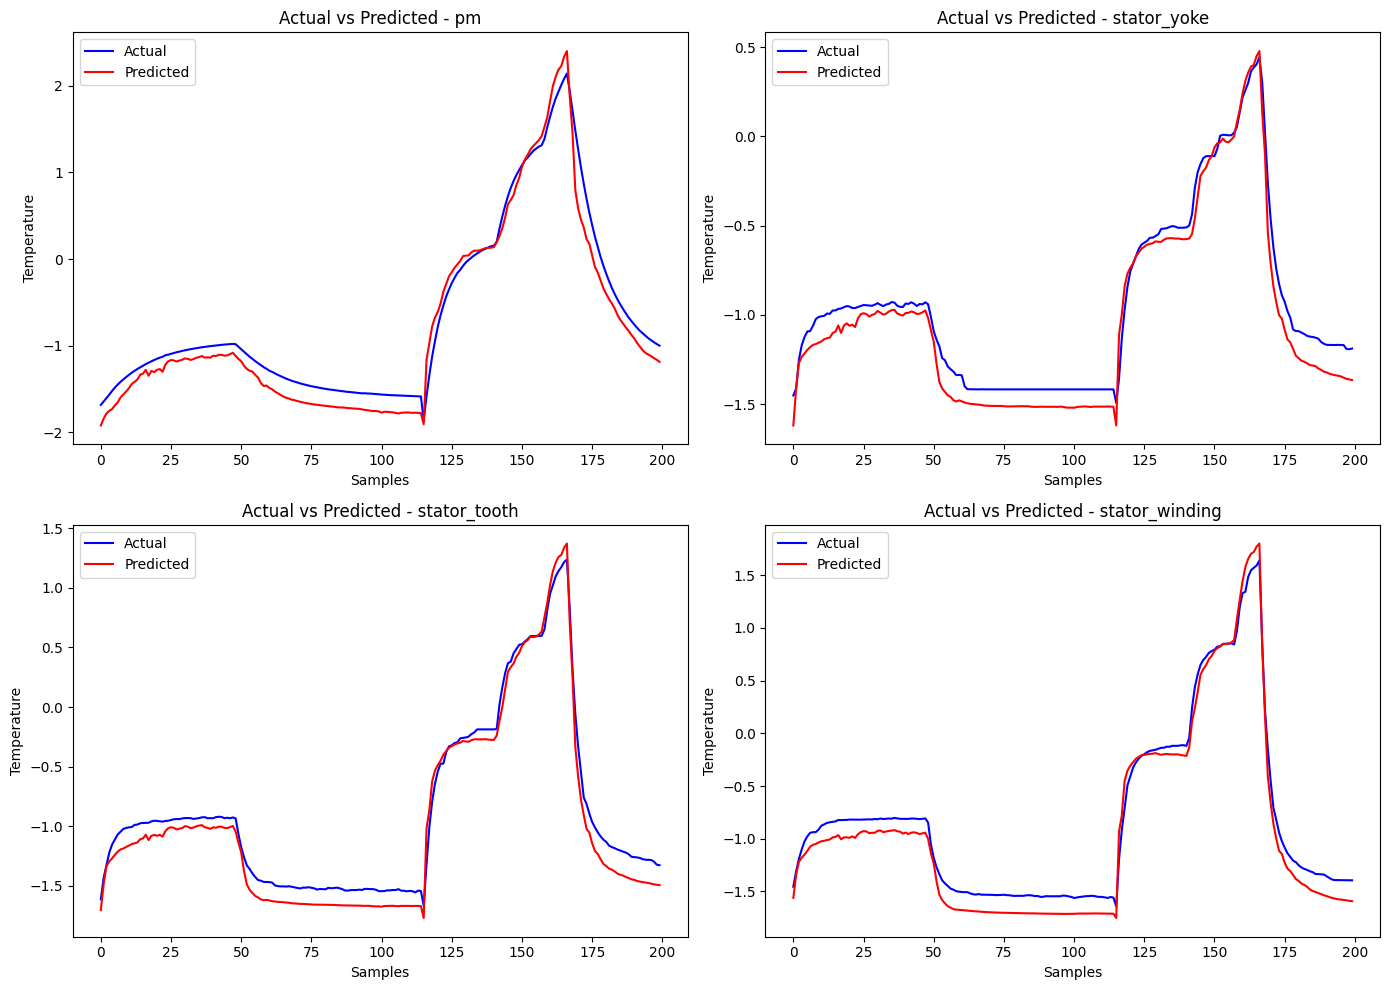

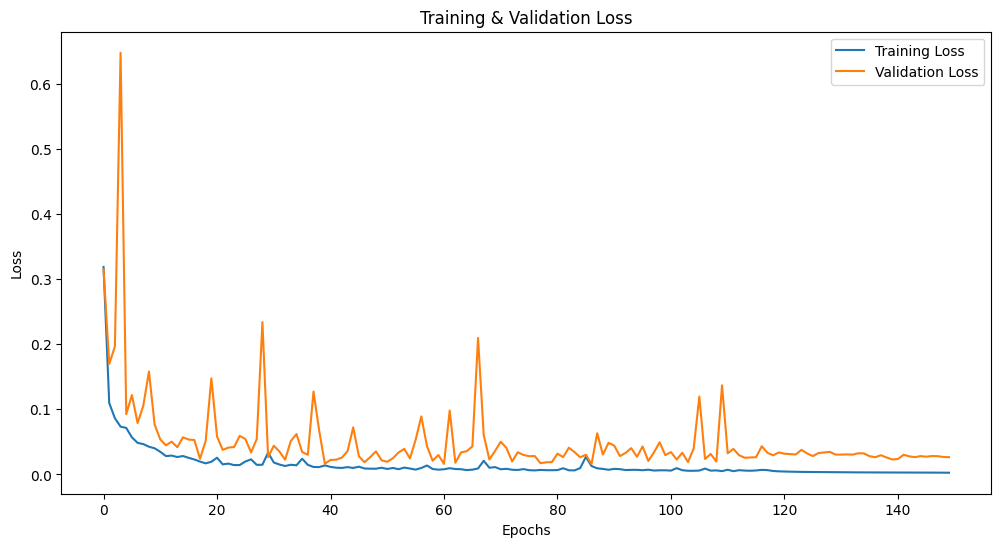

In [19]:
# Evaluate the model
test_loss, test_mse = tft_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test MSE: {test_mse:.4f}")

# Predict
y_pred = tft_model.predict(X_test)

# Optional: inverse transform (if using scalers)
# y_pred = target_scaler.inverse_transform(y_pred)
# y_test = target_scaler.inverse_transform(y_test)

import pickle

# Save training history to a file
with open('tft_model_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Define your target column names
target_cols = ["pm", "stator_yoke", "stator_tooth", "stator_winding"]

# Plot predictions vs actuals for each temperature
plt.figure(figsize=(14, 10))
for i, col in enumerate(target_cols):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_test[:200, i], label='Actual', color='blue')
    plt.plot(y_pred[:200, i], label='Predicted', color='red')
    plt.title(f'Actual vs Predicted - {col}')
    plt.xlabel('Samples')
    plt.ylabel('Temperature')
    plt.legend()
plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()


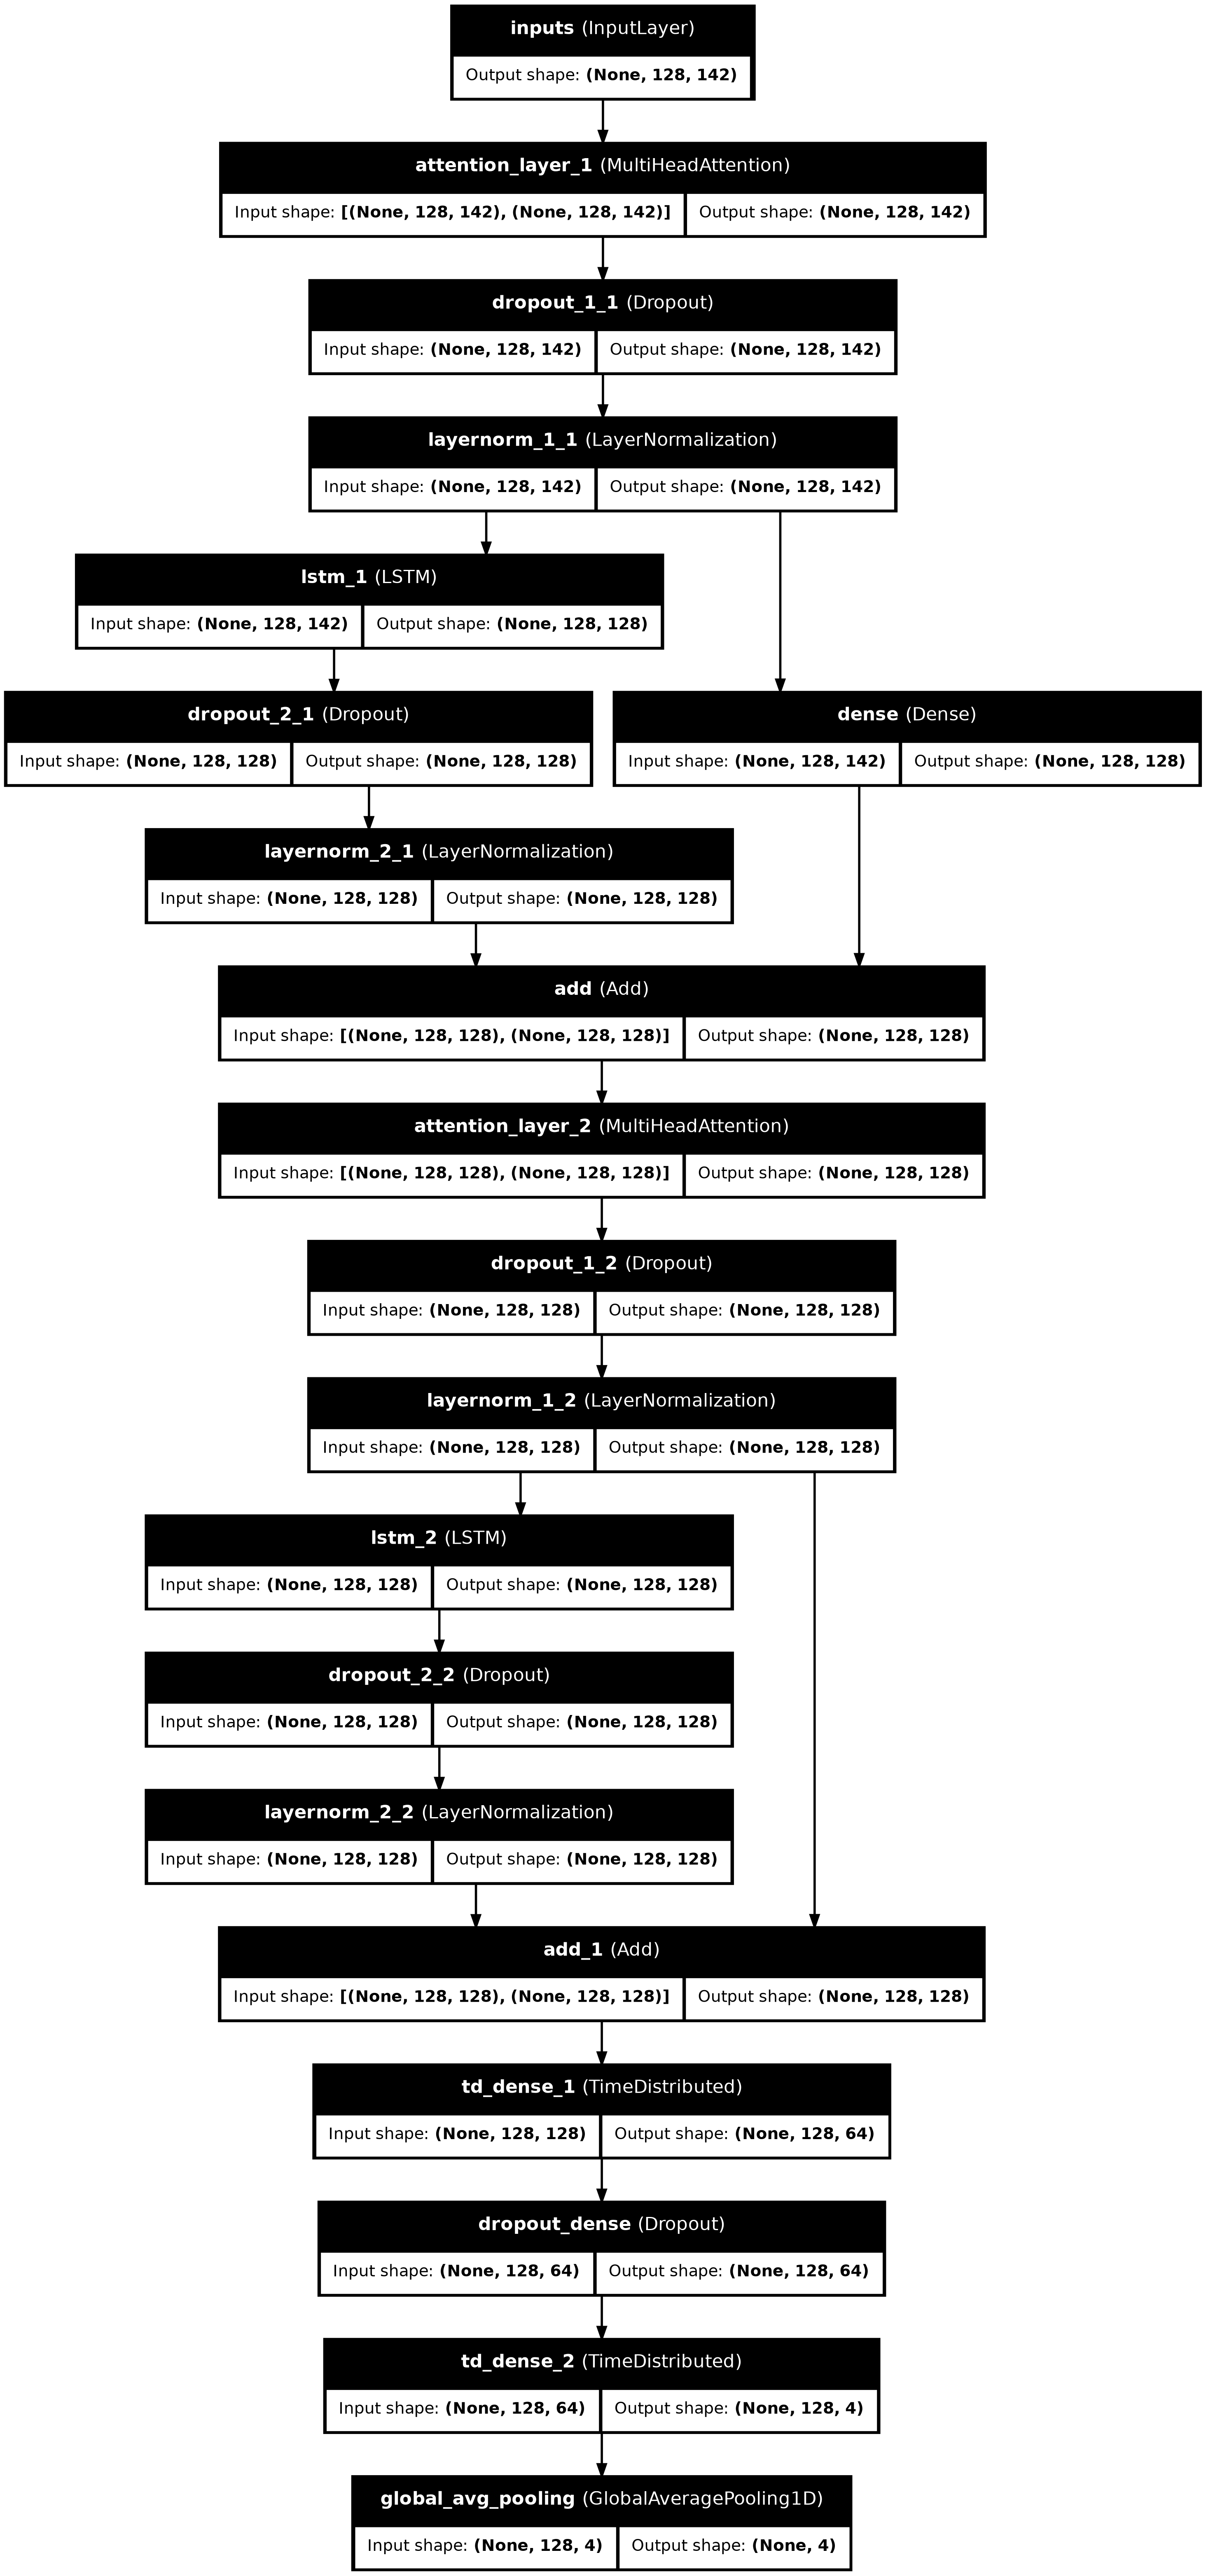

In [20]:
from tensorflow.keras.utils import plot_model

plot_model(tft_model, show_shapes=True, show_layer_names=True, to_file='tft_model.png')


In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error

# model = 

def permutation_feature_importance(model, X_val, y_val, metric=mean_squared_error):
    baseline_preds = model.predict(X_val)
    baseline_score = metric(y_val, baseline_preds)

    importances = []

    for i in range(X_val.shape[2]):  # Loop through each feature
        X_val_permuted = X_val.copy()
        np.random.shuffle(X_val_permuted[:, :, i])  # Shuffle feature i across all samples
        permuted_preds = model.predict(X_val_permuted)
        permuted_score = metric(y_val, permuted_preds)
        
        importance = permuted_score - baseline_score
        importances.append(importance)

    return np.array(importances)


In [22]:
importances = permutation_feature_importance(tft_model, X_val, y_val)
for i, imp in enumerate(importances):
    print(f"Feature {i}: Importance = {imp:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


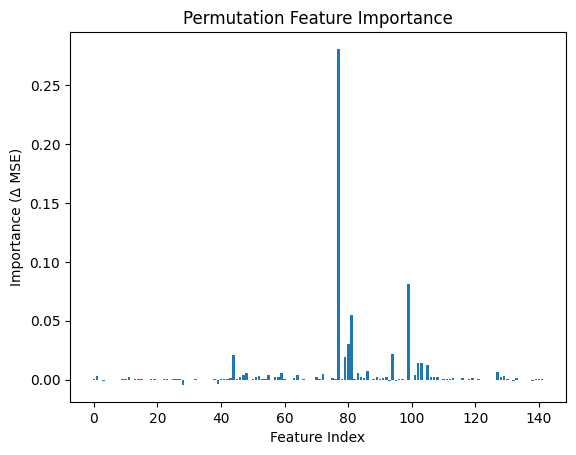

In [23]:
import matplotlib.pyplot as plt

plt.bar(range(len(importances)), importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance (Δ MSE)")
plt.title("Permutation Feature Importance")
plt.show()


In [24]:
import numpy as np

# Get indices of top 5 features (descending importance)
top_5_indices = np.argsort(importances)[::-1][:5]

# Print top 5
print("Top 5 important features (by index):")
for rank, idx in enumerate(top_5_indices, 1):
    print(f"{rank}. {x_cols[idx]} (index {idx}) - Importance: {importances[idx]:.4f}")


Top 5 important features (by index):
1. coolant_ew_rolling_mean_600 (index 77) - Importance: 0.2808
2. coolant_ew_rolling_mean_3600 (index 99) - Importance: 0.0813
3. i_d_ew_rolling_mean_600 (index 81) - Importance: 0.0553
4. motor_speed_ew_rolling_mean_600 (index 80) - Importance: 0.0307
5. profile_id_ew_rolling_std_600 (index 94) - Importance: 0.0222
